In [1]:
import seaborn as sns
sns.set()

# Clustering

A very widely used unsupervised machine learning algorithm is clustering. It can be applied in a variety of ways, the example we will focus on will be clustering customers into segments based on their annual spending on a variety of products. **Clustering customers based on their behavior** or other characteristics is a crucial aspect that allows a business to know their market, better tailor marketing efforts, and improve product development strategies. We will revisit the data set containing wholesale customers purchasing information that contains data about customers' annual spending on different products.

Let's load in the data we will be working with and inspect the first couple of rows.

In [2]:
import pandas as pd



In [3]:
df_wholesale = pd.read_csv('data/Wholesale_customers.csv')
df_wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,3,12669,9656,7561,214,2674,1338
1,0,3,7057,9810,9568,1762,3293,1776
2,0,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,0,3,22615,5410,7198,3915,1777,5185


The '`Channel`' describes whether a customer is a hotel/restaurant/cafe or not and '`Region`' describes where they are from. For the purpose of clustering our customers we will only focus on their spending habits, so we will only use  information about customers annual spending (reported in euros) on fresh products, milk products, grocery, frozen products, detergents and paper products, and delicatessen products.

In [4]:
df_spending = df_wholesale.iloc[:, 2:]
df_spending.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


We want to get a general idea of what kinds of customers we have in this data. To do so, our plan will be to organize this data into groups, such that customers in the same group are more similar to one another than they are to customers in other groups. Then, we might see, for instance, that one group tends to buy a lot of milk products and not many detergents and paper products. Based on these preferences, we can obtain some insight into defining characteristics of our customer base. 

Clustering is *not* classification. There are no true values we're trying to predict, and we don't know how many groups are appropriate to identify in the data. Instead, clustering gives us a set of methods for defining clusters and a set of metrics for evaluating how well those clusters partition the data, and it is left to us as data scientists to assess the clusters and find insights. There are many different clustering techniques that take a variety of approaches to solve the problem, so in this notebook we will cover only the basics of clustering, but it should be enough to get you started.

## K-Means clustering

K-Means is one of the simplest clustering algorithms which allows us to identify clusters of data points within our data. We define the number of clusters we want to find and the algorithm identifies which data points belong to each cluster based on similarity (or distance measured in feature space) between data points. 

Before we apply K-Means to our customers data, let's first look at a toy example of clustering on example data that only has two features. Below we generate the data, we will use `np.random.normal` function to create three clusters of normally distributed points in 2 dimensions.

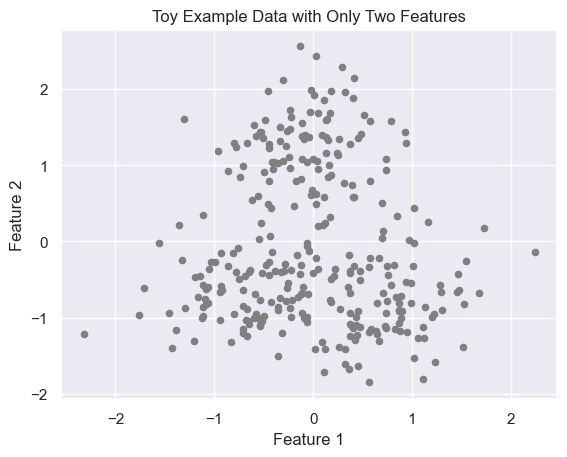

In [5]:
# Generate a blob of points
import numpy as np
from matplotlib import pylab as plt

np.random.seed(42)
toy_data = np.vstack((np.random.normal(0, 0.5, (100, 2)) + np.array([0, 1.2]),
                np.random.normal(0, 0.5, (100, 2)) + np.array([-0.7, -0.7]),
                np.random.normal(0, 0.5, (100, 2)) + np.array([0.7, -0.7])))

plt.scatter(*toy_data.T, c='0.5', s=20)
plt.title('Toy Example Data with Only Two Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

Let's find 3 clusters in this data. We will import scikit-learn's `KMeans` and train it.

In [6]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=6)
km.fit(toy_data)

KMeans(n_clusters=6)

Now we have a fitted `KMeans` model which has several attributes, one of the very useful ones is `cluster_centers_` which contains the centers of the obtained clusters. Can you explain why the output of the cell below has 3 rows and 2 columns?

In [7]:
km.cluster_centers_

array([[ 0.68792241, -1.16101235],
       [-0.29045259,  0.925514  ],
       [-0.94927532, -0.75662043],
       [ 0.15228507,  1.60811533],
       [ 1.09505522, -0.24383518],
       [-0.08797747, -0.48315401]])

Let's plot the data again, this time together with the obtained cluster centers. We have defined a function which plots the data points and colors them according to their assigned clusters. We wrote it such that we can use it with a slider that will allow us to see how the center clusters migrate to their final position during fitting of the model.

In [1]:
from ipywidgets import interact
from pylib.plotting import plot_kmeans

interact(plot_kmeans(toy_data, n=5), train_steps=(0, 11, 1));

ModuleNotFoundError: No module named 'pylib.plotting'

The way that the training of a K-Means model works is we start with cluster centers at random positions. Then at every iteration step each data point is assigned to the cluster whose center is closest to the data point. After all points are assigned a cluster, new cluster centers are computed as centroids of current clusters. After this is repeated several times, the algorithm converges to final centroid positions.

### K-Means in mathematical terms

In mathematical terms we could write this in the following way: A K-Means model assigns a collection of clusters $C = \{C_1, C_2, \dots, C_K\}$ that minimizes

$$ \mbox{argmin}_C \sum_{k=1}^K \sum_{X_j \in C_k} \| X_{j} - \mu_k \|^2 $$

where $\mu_k$ is the center of the points of cluster $C_k$. The model is trained by first initializing $\mu_k$ to some values (can be random values) and then by iterating over the following two steps:

1. Assign $X_{j}$ to the cluster $C_k$ that minimizes $\|X_{j} - \mu_k\|^2$.
1. Recompute $\mu_k$ by averaging over all the points $X_{j}$ in the cluster $C_k$.

Notice that both iterative steps lower the objective (the algorithm is greedy) and there are only a finite number of possible partitions of the points so the algorithm is guaranteed to converge.  But the converged solution may not be globally optimal. Note, by default, `KMeans` runs the clustering algorithm ten times with different centroid seeds, taking the best result, in terms of inertia (defined below), of the runs. The number of runs is controlled by `n_init`.

In [9]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit(toy_data)

KMeans(n_clusters=2)

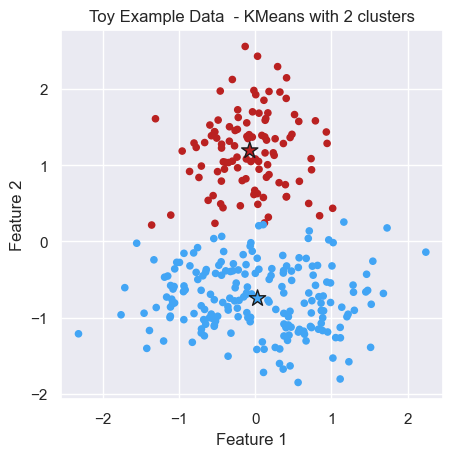

In [10]:
from matplotlib import pylab as plt
        
colors = ['#ba2121ff', '#42a5f5ff']
centers = km.cluster_centers_.T
cols = [colors[label] for label in km.labels_]
plt.scatter(*toy_data.T, s=20, c=cols)
plt.scatter(*centers, c=colors, marker='*', s=150,
            linewidth=1, edgecolors='k')
plt.axis('image')
plt.title('Toy Example Data  - KMeans with 2 clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2');

## Metrics for clustering

In the two-dimensional toy example above, the data has only two features, so it is easy to visually assess the validity of the clusters. As a result, we can tell that 3 clusters seems like a reasonable number for fitting the pattern of our data. But how can we evaluate the results of a clustering algorithm if we have more than 2 or 3 features and we can not visualize the data as easily? In particular, how do we know how many clusters to identify? 

We need clustering metrics! Just like in the case of supervised learning, the appropriate clustering error metrics give us a way to compare goodness-of-fit for different models. 

There are many metrics for clustering, we will focus on two of the most common ones: inertia and silhouette. 

### Inertia

The simplest metric for clustering is **inertia** which is based on the distance from each data point to the center of the cluster to which it is assigned.
 Let $\mu_k$ be the mean of all data points in cluster $k$ (therefore $\mu_k$ is the centroid of cluster $k$) i.e. for all elements $X_{j} \in C_k$,
 
$$\mu_k = \frac{1}{|C_k|} \sum_{X_{j} \in C_k} X_{j}.$$


Then, for each cluster, the inertia is given by the average squared distance between each point in the cluster $X_{j} \in C_k$ and the center $\mu_k$

$$i_k = \frac{1}{|C_k|} \sum_{X_{j} \in C_k} \| X_{j} - \mu_k\|^2\,$$


and the total inertia is defined as the sum of the inertia of each cluster:
$$I = \sum_k i_k.$$

![inertia](images/clustering_inertia.svg)

### Silhouette

Another metric is called the **silhouette coefficient**. For a data point $X_j$, the silhouette coefficient can be computed as follows. Let $a_j$ be the mean distance between data point $X_j$ and all the other points in the cluster that $X_j$ belongs to. And let $b_j$ be the mean distance between data point $X_j$ and all the points in the next nearest cluster. Then the silhouette coefficient for point $X_j$ is given by

$$ s_j = \frac{b_j-a_j}{\max(a_j, b_j)}\,. $$

When this is averaged over all the points in a given cluster, it measures how tightly grouped the points in that cluster are. When it is averaged over all points in the data set, it measures how well the data have been clustered.

![silhouette](images/clustering_silhouette_coef.svg)

## Choosing the number of clusters

Now that we have clustering metrics, we can use these to assess how good our clustering model is and this can help us determine how many clusters there are in our data. 

Let's start by plotting inertia as a function of the number of clusters. Shown below is a plot of inertia for various numbers of clusters using our example two-dimensional data.

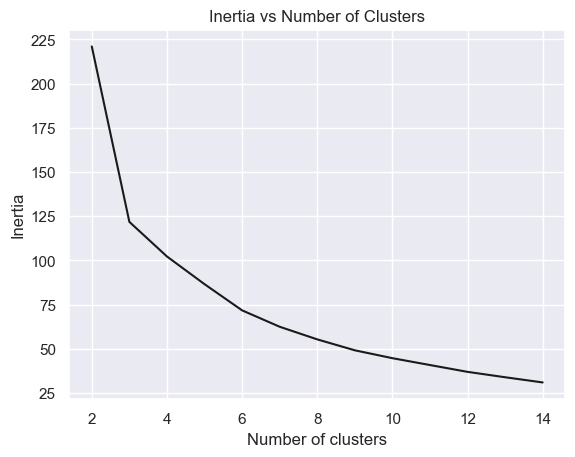

In [11]:
inertias = []

for n_clusters in range(2, 15):
    km = KMeans(n_clusters=n_clusters).fit(toy_data)
    inertias.append(km.inertia_)
    
plt.plot(range(2, 15), inertias, 'k')
plt.title("Inertia vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia");

We see that inertia continues to decrease as we increase the number of clusters in the model. In fact, this is always the case! A notable downside of inertia as a model selection method (i.e. for selecting `n_clusters`) is that it continues to decrease with each additional cluster. 

In many cases, however, the inertia decreases most sharply for the first few clusters, and then the improvements begin to taper. In the above plot we can see this after $n=3$. This point is referred to as the "elbow" of the plot, and this point can sometimes be used as the appropriate number of clusters to use. But often in real world data this elbow is not so clearly defined.

Other times, business constraints may impose the maximum number of clusters. For example, the location of the elbow may be at around 50 clusters but it's not practical to define 50 different types of customers for more direct ad targeting. Our budget may only allow for creating 10 specialized ads.

Silhouette is much more amenable to comparing models across multiple cluster sizes because it has a fixed scale and won't always improve as `n_clusters` increases. Let's compute the silhouette score for a range of `n_clusters` values for our two-dimensional data.

In [12]:
from sklearn.metrics import silhouette_score

In [13]:
for n_clusters in range(2, 9):
    km = KMeans(n_clusters=n_clusters)
    km.fit(toy_data)
    
    # Predict the cluster for each data point
    preds = km.predict(toy_data)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(toy_data, preds, metric='euclidean')
    print('For n_clusters = {}, the average silhouette_score is : {}'
          .format(n_clusters, score.round(5)))

For n_clusters = 2, the average silhouette_score is : 0.49401
For n_clusters = 3, the average silhouette_score is : 0.49921
For n_clusters = 4, the average silhouette_score is : 0.41813
For n_clusters = 5, the average silhouette_score is : 0.37237
For n_clusters = 6, the average silhouette_score is : 0.34504
For n_clusters = 7, the average silhouette_score is : 0.34659
For n_clusters = 8, the average silhouette_score is : 0.3446


Notice that the silhouette score is highest for $n=3$ (although $n=2$ is quite similar as well) and $n=3$ matches how we constructed this data and what we observed through visual inspection.

## Clustering on customers data

Now we are ready to fit a K-Means model to our customers' data. Let's prepare the data before we feed it into the clustering algorithm. We will first filter out any outliers from the data. Outliers are not such a big problem in this data set, but the results will improve if we make this the first step. We will import and use a function that detects outliers and filters them out. We defined this function in a separate script (for those interested in more you can find it the `pylib` folder).

In [14]:
from pylib.outliers import filter_outliers

df_spending_cleaned = filter_outliers(df_spending)

In [15]:
print(f'Number of rows before cleaning: {df_spending.shape[0]}')
print(f'Number of rows after cleaning: {df_spending_cleaned.shape[0]}')

Number of rows before cleaning: 434
Number of rows after cleaning: 397


### Scale your data

Remember that K-Means clustering uses the distance between points to define clusters. This means that all features should be scaled such that their units are comparable. Otherwise, certain features may seem artificially to have more variance than others. 

In the case of the customers data set, all our features (annual spending on different products) are measured in the same units, so it could actually happen that scaling the data in this case would mean losing important information. This is something we need to be careful about and check. In this particular case it turns out that whether we scale the data with scikit-learn's `StandardScaler` transformer or not doesn't impact the results very much. We will scale the data here nevertheless, but again this step is even more important when dealing with features that are using units that are not comparable (for example customer income and customer age).

We will scale the data with scikit-learn's `StandardScaler` transformer. As we know, it centers each feature around its mean and scales it by dividing by that feature's standard deviation. 

In [16]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df_spending_cleaned_scaled = pd.DataFrame(standard_scaler.fit_transform(df_spending_cleaned),
                                          columns=df_spending_cleaned.columns)
df_spending_cleaned_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.155679,1.504403,0.285557,-0.783649,0.238210,0.101340
1,-0.389173,1.547533,0.666579,-0.274419,0.470146,0.440277
2,-0.457522,1.266906,0.308908,-0.062897,0.553703,5.135868
3,0.213542,-0.864959,-0.348530,1.252616,-0.573752,0.449563
4,1.121304,0.315241,0.216643,0.433833,-0.097891,3.078258


### Dimensionality reduction

Clustering algorithms and metrics tend to be computationally complex, and this complexity scales very quickly with the number of features. As such, it is very common to reduce the dimensionality of the data before feeding into a K-Means clustering algorithm. 

In the previous notebook we talked about principal components analysis (PCA) as a method for reducing the number of features in data while retaining as much information as possible. While our customer data set does not have that many features we will still reduce the dimensionality before we proceed, if nothing else so that we can visualize the results.

Let's first perform PCA without throwing away any components, and plot the cumulative sum of the explained variance ratio so we can see how many components are required to explain a significant amount of the variation in the data.

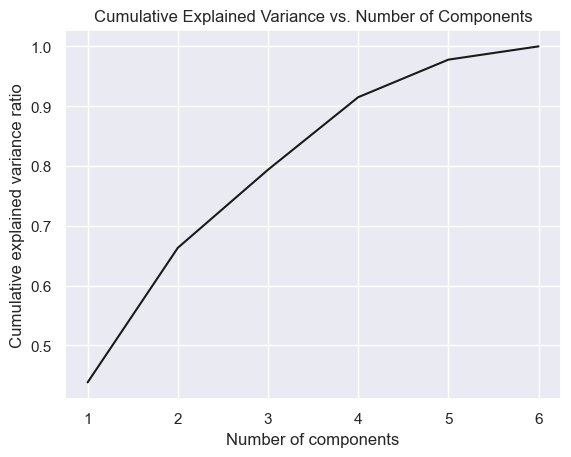

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=df_spending_cleaned_scaled.shape[1])

customers_pca_transformed = pca.fit_transform(df_spending_cleaned_scaled)

plt.plot(range(1, df_spending_cleaned_scaled.shape[1]+1), pca.explained_variance_ratio_.cumsum(), 'k')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Cumulative Explained Variance vs. Number of Components");

It looks like we would need to use 4 components to capture 90% of the variance, but 3 components capture 80% and choosing 3 will lend itself to inspecting the results with a visualization. So let's use a PCA transformer that will project our data into 3D.

In [18]:
pca3D = PCA(n_components=3)

customers_pca_3D = pca3D.fit_transform(df_spending_cleaned_scaled)

### Finding clusters

Now let's train a K-Means model on this data for a range of `n_clusters` values and compute the silhouette score for each model.

In [19]:
for n_clusters in range(2, 9):
    km = KMeans(n_clusters=n_clusters)
    km.fit(customers_pca_3D)
    
    # Predict the cluster for each data point
    preds = km.predict(customers_pca_3D)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(customers_pca_3D, preds, metric='euclidean')
    print('For n_clusters = {}, the average silhouette_score is : {}'
          .format(n_clusters, score.round(5)))

For n_clusters = 2, the average silhouette_score is : 0.44147
For n_clusters = 3, the average silhouette_score is : 0.41837
For n_clusters = 4, the average silhouette_score is : 0.43308
For n_clusters = 5, the average silhouette_score is : 0.38857
For n_clusters = 6, the average silhouette_score is : 0.36816
For n_clusters = 7, the average silhouette_score is : 0.372
For n_clusters = 8, the average silhouette_score is : 0.31209


It looks like there are probably 2 clusters in the data, but we could also choose 4. Let's see what we get for 4 clusters. We will visualize the results of a K-Means clustering model with 4 clusters by plotting the 3D data we obtained after the PCA transformation and color each data point according to the cluster it belongs to. The plot below will have two sliders, play around with them to observe the data from different angles.

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import IntSlider

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(customers_pca_3D)

cols = kmeans.predict(customers_pca_3D)
colors = ['#ba2121ff', '#42a5f5ff', '#efa016ff', '#000000ff', '#10bb20' ]
centroids = kmeans.cluster_centers_

def plot_rotate(az, el):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(elev=el, azim=az)

    x = customers_pca_3D[:,0]
    y = customers_pca_3D[:,1]
    z = customers_pca_3D[:,2]
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3', rotation=90, labelpad=-2)

    ax.scatter(x, y, z, marker='o', s=4, color=[colors[col] for col in cols])

interact(plot_rotate, az=IntSlider(min=0, max=300, step=10, value=50, description='azimuth'), 
                      el=IntSlider(min=0, max=90, step=10, value=20, description='elevation'));

interactive(children=(IntSlider(value=50, description='azimuth', max=300, step=10), IntSlider(value=20, descri…

### Interpreting cluster centroids

We found 4 clusters and each cluster has a centroid which corresponds to the average customer of that cluster. Because we scaled our data and used PCA on it before we fed it into a K-Means model, we need to apply inverse transformations to recover average customer information.

In [21]:
# Invert PCA
scaled_centers = pca3D.inverse_transform(centroids)

# Invert standard scaler
true_centers = standard_scaler.inverse_transform(scaled_centers)

In [22]:
typical_customers = pd.DataFrame(true_centers, columns=df_spending.columns, 
                                 index=['typical customer 1', 'typical customer 2', 
                                        'typical customer 3', 'typical customer 4'])
typical_customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
typical customer 1,4360.560233,8608.159429,13315.526102,1338.363598,5758.477607,1442.857783
typical customer 2,24836.416603,4670.331040,6092.015926,2313.515845,1264.348930,2814.533639
typical customer 3,9458.667704,2319.741725,3122.022565,1745.679418,840.258061,586.388622
typical customer 4,13623.605869,3377.307370,3721.281035,9683.026771,547.755023,1283.453041


In [23]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(customers_pca_3D)

centroids = kmeans.cluster_centers_

In [24]:
# Invert PCA
scaled_centers = pca3D.inverse_transform(centroids)

# Invert standard scaler
true_centers = standard_scaler.inverse_transform(scaled_centers)

In [25]:
typical_customers = pd.DataFrame(true_centers, columns=df_spending.columns, 
                                 index=['typical customer 1', 'typical customer 2', 
                                        'typical customer 3', 'typical customer 4',
                                       'typical customer 5'])
typical_customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
typical customer 1,10433.825301,2044.168488,2632.935884,1847.080587,558.466345,631.835656
typical customer 2,7110.919691,6045.056128,9168.397224,1171.202162,3731.660083,1168.065286
typical customer 3,13623.605869,3377.307370,3721.281035,9683.026771,547.755023,1283.453041
typical customer 4,26678.973732,4962.099792,6427.378574,2708.097497,1292.699461,3083.734543
typical customer 5,2086.132292,10270.018363,16049.544334,1236.193257,7130.090532,1566.840385


In [26]:
pca2D = PCA(n_components=2)

customers_pca_2D = pca2D.fit_transform(df_spending_cleaned_scaled)

In [27]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2, 9):
    km = KMeans(n_clusters=n_clusters)
    km.fit(customers_pca_2D)
    
    # Predict the cluster for each data point
    preds = km.predict(customers_pca_2D)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(customers_pca_2D, preds, metric='euclidean')
    print('For n_clusters = {}, the average silhouette_score is : {}'
          .format(n_clusters, score.round(5)))

For n_clusters = 2, the average silhouette_score is : 0.50712
For n_clusters = 3, the average silhouette_score is : 0.45996
For n_clusters = 4, the average silhouette_score is : 0.44027
For n_clusters = 5, the average silhouette_score is : 0.43393
For n_clusters = 6, the average silhouette_score is : 0.36529
For n_clusters = 7, the average silhouette_score is : 0.37675
For n_clusters = 8, the average silhouette_score is : 0.38811


In [28]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(customers_pca_2D)

centroids = kmeans.cluster_centers_
scaled_centers = pca2D.inverse_transform(centroids)
true_centers = standard_scaler.inverse_transform(scaled_centers)

typical_customers = pd.DataFrame(true_centers, columns=df_spending.columns, 
                                 index=['typical customer 1', 'typical customer 2'])
typical_customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
typical customer 1,12469.274472,2710.834942,3463.483455,3029.203502,767.464190,1006.800658
typical customer 2,7260.882272,8549.232401,13085.605590,1422.635368,5482.452196,1749.745880


## Summary

- clustering is an unsupervised learning algorithm that can be useful in a variety of cases
- K-Means is one of the simplest clustering algorithms which identifies which data point belongs to which cluster based on distance between data points
- the main two metrics for clustering are inertia and silhouette score
- we can find the optimum number of clusters by choosing the number of clusters with the highest silhouette score
- it is important to scale our data before we feed it into a K-Means algorithm if the units of the features are not comparable
- we can reduce the dimensionality of our data before we feed it into a K-Means algorithm
- examining summary statistics of different clusters gives us actionable insights from data